# Rabbits and foxes

There are initially 400 rabbits and 200 foxes on a farm (but it could be two cell types in a 96 well plate or something, if you prefer bio-engineering analogies). Plot the concentration of foxes and rabbits as a function of time for a period of up to 600 days. The predator-prey relationships are given by the following set of coupled ordinary differential equations:

\begin{align}
\frac{dR}{dt} &= k_1 R - k_2 R F \tag{1}\\
\frac{dF}{dt} &= k_3 R F - k_4 F \tag{2}\\
\end{align}

* Constant for growth of rabbits $k_1 = 0.015$ day<sup>-1</sup>
* Constant for death of rabbits being eaten by foxes $k_2 = 0.00004$ day<sup>-1</sup> foxes<sup>-1</sup>
* Constant for growth of foxes after eating rabbits $k_3 = 0.0004$ day<sup>-1</sup> rabbits<sup>-1</sup>
* Constant for death of foxes $k_4 = 0.04$ day<sup>-1</sup>

*This problem is based on one from Chapter 1 of H. Scott Fogler's textbook "Essentials of Chemical Reaction Engineering".*


In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

# Now let's try some Kinetic Monte Carlo

We wish to implement a Kinetic Monte Carlo algorithm to simulate the same situation. See https://en.wikipedia.org/wiki/Kinetic_Monte_Carlo for details.

We'll assume the numbers of rabbits and foxes (starting at 400 and 200) are actual rabbits and foxes, not "rabbit densities" for example, and so must always remain integers: you can't have half a rabbit or half a fox.

There are four events, with rates that are straightforward to calculate, so the rejection-free algorithm is suitable:
* `rabbit_birth = k_1 * rabbits`
* `rabbit_death = k2 * rabbits * foxes`
* `fox_birth = k3 * rabbits * foxes`
* `fox_death = k4 * foxes`


Use a Kinetic Monte Carlo simulation to determine
1. The expected location of the second peak in foxes (eg. 425 days, 2800 foxes), on occasions that there is one (eg. if there's a peak that's  >200 days and >100 foxes)
2. The interquartile range of the second peak in foxes (eg. 411-443 days, 2700-3120 foxes).
3. The probability that the foxes die out before 600 days are complete

Make sure you've done enough simulations to be suitably confident in your answers (given the precision you think appropriate).

# Your turn!

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

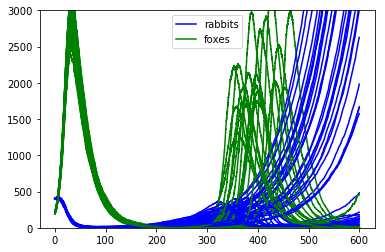

Everything died 18 times out of 1000 or 1.8%
Foxes died 708 times out of 1000 or 70.8%


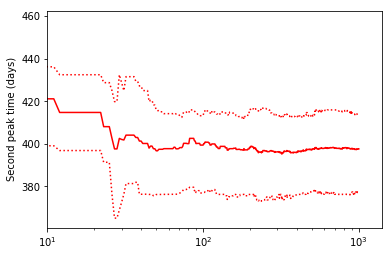

Second peak (days) is 397.6 with IQR [377.7-413.9] 


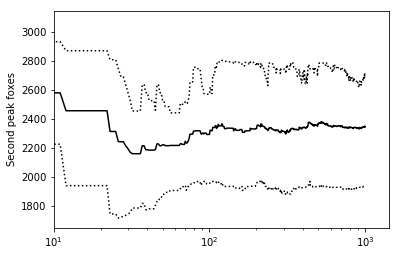

Second peak (foxes) is 2347.2 with IQR [1933.5-2689.5] 


In [2]:
import random
random.seed(1) # so results don't change every time I execute
np.random.seed(1) # same thing for numpy
k1 = 0.015
k2 = 0.00004
k3 = 0.0004
k4 = 0.04
end_time = 600

def get_rates(rabbits, foxes):
    """
    Return the rates (expected events per day) as a tuple:
    (rabbit_birth, rabbit_death, fox_birth, fox_death)
    """
    rabbit_birth = k1 * rabbits 
    rabbit_death = k2 * rabbits * foxes
    fox_birth = k3 * rabbits * foxes 
    fox_death = k4 * foxes
    return (rabbit_birth, rabbit_death, fox_birth, fox_death)

dead_foxes = 0
dead_everything = 0
runs = 1000

second_peak_times = []
second_peak_foxes = []

mean_times = np.zeros(runs)
mean_foxes = np.zeros(runs)
upper_quartile_times = np.zeros(runs)
lower_quartile_times = np.zeros(runs)
upper_quartile_foxes = np.zeros(runs)
lower_quartile_foxes = np.zeros(runs)


for run in range(runs):
    print('.',end='')
    time = 0
    rabbit = 400
    fox = 200
    # we don't know how long these will be so start as lists and convert to arrays later
    times = []
    rabbits = []
    foxes = []

    while time < end_time:
        times.append(time)
        rabbits.append(rabbit)
        foxes.append(fox)
        (rabbit_birth, rabbit_death, fox_birth, fox_death) = rates = get_rates(rabbit, fox)
        sum_rates = sum(rates)
        if sum_rates == 0:
            # print("everything dead at t=",time)
            dead_everything += 1
            times.append(end_time)
            rabbits.append(rabbit)
            foxes.append(fox)
            break
        wait_time = random.expovariate( sum_rates )
        time += wait_time
        choice = random.uniform(0, sum_rates)
        # Imagine we threw a dart at a number line with span (0, sum_rates) and it hit at "choice"
        # Foxes change more often than rabbits, so we'll be faster if we check them first!
        choice -= fox_birth
        if choice < 0:
            fox += 1 # fox born
            continue
        choice -= fox_death
        if choice < 0:
            fox -= 1 # fox died
            if fox == 0:
                #print("Foxes all died at t=",time)
                dead_foxes += 1
                ## Break here to speed things up (and not track the growing rabbit population)
            continue
        if choice < rabbit_birth:
            rabbit += 1 # rabbit born
            continue
        rabbit -= 1 # rabbit died
    
    times = np.array(times)
    rabbits = np.array(rabbits)
    foxes = np.array(foxes)
    
    index_of_second_peak = np.argmax(foxes*(times>200)*(foxes>100))
    if index_of_second_peak:
        second_peak_times.append(times[index_of_second_peak])
        second_peak_foxes.append(foxes[index_of_second_peak])
    
    if len(second_peak_times)>0:
        mean_times[run] = np.mean(second_peak_times)
        mean_foxes[run] = np.mean(second_peak_foxes)
        upper_quartile_times[run] = np.percentile(second_peak_times,75)
        lower_quartile_times[run] = np.percentile(second_peak_times,25)
        upper_quartile_foxes[run] = np.percentile(second_peak_foxes,75)
        lower_quartile_foxes[run] = np.percentile(second_peak_foxes,25)

    # We don't want to plot too many lines, but would be fun to see a few
    if run < 50:
        plt.plot(times, rabbits, 'b')
        plt.plot(times, foxes, 'g')
plt.legend(['rabbits','foxes'],loc="best") # put the legend at the best location to avoid overlapping things
plt.ylim(0,3000)
plt.show()


print("Everything died {} times out of {} or {:.1f}%".format(dead_everything, runs, 100*dead_everything/runs))
print("Foxes died {} times out of {} or {:.1f}%".format(dead_foxes, runs, 100*dead_foxes/runs))

plt.semilogx(mean_times,'-r')
plt.semilogx(upper_quartile_times,':r')
plt.semilogx(lower_quartile_times,':r')
plt.ylabel('Second peak time (days)')
plt.xlim(10)
plt.show()
print("Second peak (days) is {:.1f} with IQR [{:.1f}-{:.1f}] ".format(mean_times[-1], lower_quartile_times[-1], upper_quartile_times[-1]))


plt.semilogx(mean_foxes,'-k')
plt.semilogx(upper_quartile_foxes,':k')
plt.semilogx(lower_quartile_foxes,':k')
plt.ylabel('Second peak foxes')
plt.xlim(10)
plt.show()
print("Second peak (foxes) is {:.1f} with IQR [{:.1f}-{:.1f}] ".format(mean_foxes[-1], lower_quartile_foxes[-1], upper_quartile_foxes[-1]))


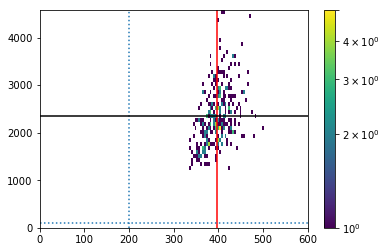

In [3]:
from matplotlib.colors import LogNorm
plt.hist2d(second_peak_times, second_peak_foxes, bins=40, norm=LogNorm())
plt.xlim(0,600)
plt.ylim(0)
plt.colorbar()
plt.axvline(200,linestyle=':')
plt.axvline(mean_times[-1],color='r')
plt.axhline(100,linestyle=':')
plt.axhline(mean_foxes[-1],color='k')
plt.show()
